# Préparation & preprocessing

In [6]:
# ---
# 1) Préparation : on charge le dataset et on prépare les features
# Cible = MonthlyIncome. On encode les variables catégorielles et on normalise les numériques.
# ---

import os, urllib.request, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Dataset
CSV_NAME = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

# Chargement + ménage léger
df = pd.read_csv(CSV_NAME).copy()
drop_cols = [c for c in ["EmployeeCount","Over18","StandardHours","EmployeeNumber"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Cible et variables explicatives
assert "MonthlyIncome" in df.columns, "MonthlyIncome manquant."
y = df["MonthlyIncome"].values
X = df.drop(columns=["MonthlyIncome"])

# Colonnes catégorielles / numériques
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Préprocesseur : OHE + StandardScaler
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # compat anciennes versions

prepro = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("num", StandardScaler(), num_cols)
])

print(f"X: {X.shape}, y mean={y.mean():.1f}")

X: (1470, 30), y mean=6502.9


# Cross-Validation : comparatif des modèles (OOF = vraies prédictions “hors-pli”)

In [7]:
# ---
# 2) Cross-Validation (OOF) : on évalue les modèles sur des données jamais vues.
# Résultat : des erreurs > 0 (réalistes), donc fairness exploitable.
# ---

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def mape_safe(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))) if mask.sum() else np.nan

models = {
    "LinReg": LinearRegression(),
    "Tree":   DecisionTreeRegressor(random_state=42),
    "RF":     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}

# On calcule des prédictions OOF (cross_val_predict) pour chaque modèle
results = []
oof_preds = {}  # pour garder les yhat OOF par modèle

for name, reg in models.items():
    pipe = Pipeline([("prep", prepro), ("reg", reg)])
    yhat_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict", n_jobs=-1)
    oof_preds[name] = yhat_oof

    mae  = mean_absolute_error(y, yhat_oof)
    r2   = r2_score(y, yhat_oof)
    mape = mape_safe(y, yhat_oof) * 100

    results.append({"Model": name, "MAE": round(mae,2), "R²": round(r2,3), "MAPE (%)": round(mape,2)})

scores_cv = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
scores_cv

,Model,MAE,R²,MAPE (%)
0,RF,777.10,0.952,17.20
1,LinReg,871.84,0.941,18.55
2,Tree,1056.81,0.906,23.07


# Choix du meilleur modèle (par MAE) + scatter y vs ŷ (OOF)

✅ Modèle retenu (CV): RF


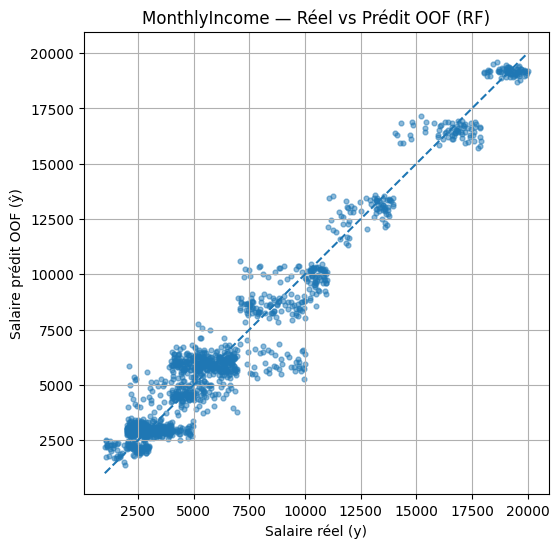

In [8]:
# ---
# 3) On retient le meilleur par MAE (souvent le RF ici) et on trace y vs ŷ (OOF).
# La ligne pointillée y=x est juste un repère visuel.
# ---

best_name = scores_cv.iloc[0]["Model"]
yhat_oof = oof_preds[best_name]

print(f"✅ Modèle retenu (CV): {best_name}")

plt.figure(figsize=(6,6))
plt.scatter(y, yhat_oof, s=12, alpha=0.5)
minv, maxv = float(min(y.min(), yhat_oof.min())), float(max(y.max(), yhat_oof.max()))
plt.plot([minv,maxv],[minv,maxv],'--')
plt.xlabel("Salaire réel (y)")
plt.ylabel("Salaire prédit OOF (ŷ)")
plt.title(f"MonthlyIncome — Réel vs Prédit OOF ({best_name})")
plt.grid(True)
plt.show()

# Fairness (OOF) : MAPE par groupes + ratios de parité

In [9]:
# ---
# 4) Fairness sur les prédictions OOF : on calcule MAPE par groupe,
# puis un ratio simple (ex: Femmes/Hommes). Les chiffres ont enfin du sens.
# ---

def fairness_mape_table(X_feat, y_true, y_pred, group_col, rename=None):
    if group_col not in X_feat.columns:
        return None
    tmp = pd.DataFrame({"grp": X_feat[group_col], "y": y_true, "yhat": y_pred})
    rows = []
    # observed=False = comportement actuel de pandas, on l'explicite pour rester clean
    for g, s in tmp.groupby("grp", observed=False):
        rows.append({"grp": g, "n": int(s.shape[0]), "MAPE (%)": mape_safe(s["y"], s["yhat"]) * 100})
    tab = pd.DataFrame(rows)
    if rename: tab.rename(columns={"grp": rename}, inplace=True)
    return tab

def ratio_parity(tab, colname, a, b):
    if tab is None or colname not in tab.columns: return np.nan
    va = tab.loc[tab[colname]==a, "MAPE (%)"]
    vb = tab.loc[tab[colname]==b, "MAPE (%)"]
    if len(va)==0 or len(vb)==0: return np.nan
    denom = float(vb.iloc[0])
    return float(va.iloc[0]) / denom if denom != 0 else np.nan

# Tables fairness
tab_gender  = fairness_mape_table(X, y, yhat_oof, "Gender", "Gender")
tab_marital = fairness_mape_table(X, y, yhat_oof, "MaritalStatus", "MaritalStatus")

print("== Fairness par Genre (OOF) ==")
print(tab_gender if tab_gender is not None else "Colonne Gender indisponible.")
if tab_gender is not None and set(["Female","Male"]).issubset(set(tab_gender["Gender"])):
    print(f"Parité relative (MAPE Femmes/Hommes) = {ratio_parity(tab_gender,'Gender','Female','Male'):.3f}×")

print("\n== Fairness par Statut marital (OOF) ==")
print(tab_marital if tab_marital is not None else "Colonne MaritalStatus indisponible.")
if tab_marital is not None and set(["Married","Single"]).issubset(set(tab_marital["MaritalStatus"])):
    print(f"Parité relative (MAPE Mariés/Célibataires) = {ratio_parity(tab_marital,'MaritalStatus','Married','Single'):.3f}×")

# Tranches d'âge (si Age présent)
if "Age" in X.columns:
    bins = (0,29,39,49,200)
    labels = ["<30","30-39","40-49","50+"]
    age_group = pd.cut(X["Age"], bins=bins, labels=labels, include_lowest=True, right=True)
    tmp = pd.DataFrame({"age_group": age_group, "y": y, "yhat": yhat_oof})
    rows_age = []
    for g, s in tmp.groupby("age_group", observed=False):
        rows_age.append({"age_group": g, "n": int(s.shape[0]), "MAPE (%)": mape_safe(s["y"], s["yhat"]) * 100})
    tab_age = pd.DataFrame(rows_age)
    print("\n== Fairness par tranches d'âge (OOF) ==")
    print(tab_age)
    # Exemple de ratio lisible : <30 / 40-49
    try:
        a = float(tab_age.loc[tab_age["age_group"]=="<30","MAPE (%)"].iloc[0])
        b = float(tab_age.loc[tab_age["age_group"]=="40-49","MAPE (%)"].iloc[0])
        print(f"Parité relative (MAPE <30 / 40-49) = {a/b:.3f}×")
    except Exception:
        pass

== Fairness par Genre (OOF) ==
   Gender    n   MAPE (%)
0  Female  588  15.631863
1    Male  882  18.240128
Parité relative (MAPE Femmes/Hommes) = 0.857×

== Fairness par Statut marital (OOF) ==
  MaritalStatus    n   MAPE (%)
0      Divorced  327  16.771372
1       Married  673  16.007576
2        Single  470  19.195726
Parité relative (MAPE Mariés/Célibataires) = 0.834×

== Fairness par tranches d'âge (OOF) ==
  age_group    n   MAPE (%)
0       <30  326  21.953897
1     30-39  622  17.461918
2     40-49  349  14.683789
3       50+  173  12.349146
Parité relative (MAPE <30 / 40-49) = 1.495×
